In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import pairwise_kernels
import sklearn.model_selection as model_selection
from sklearn.metrics import mean_squared_error
import uncertainty_sampling_multiclass as usm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("qsar_aquatic_toxicity.csv", sep = ';', header = None)
data = df.values

In [3]:
print(data.shape)

(546, 9)


In [4]:
index = np.arange(data.shape[0])
np.random.shuffle(index)

In [5]:
X = np.array(data[index[:10000], :-1], dtype = float)

In [6]:
Y = np.array(data[index[:10000], -1:], dtype = float)

In [7]:
print(X.dtype)
print(Y.dtype)

float64
float64


In [16]:
def normalize(x):
    dim = x.shape[1]
    x_min = np.min(x, axis = 0, keepdims = True)
    x_max = np.max(x, axis = 0, keepdims = True)
    inds = x_max - x_min == 0
    norm = x_max - x_min
    norm[inds] = 1.0
    return np.divide(x - x_min, norm)

In [17]:
X = normalize(X)

In [38]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, test_size=0.20, random_state=0)

In [44]:
linear = LinearRegression().fit(X_train, Y_train)
rbf = KernelRidge(alpha = 0.1, kernel = 'rbf').fit(X_train, Y_train)
poly = KernelRidge(alpha = 1.0, kernel = 'poly').fit(X_train, Y_train)

In [45]:
linear_pred = linear.predict(X_test)
rbf_pred = rbf.predict(X_test)
poly_pred = poly.predict(X_test)

In [46]:
linear_mse = mean_squared_error(Y_test, linear_pred)
print('MSE (Linear): ', "%.2f" % (linear_mse))

MSE (Linear):  2.01


In [47]:
rbf_mse = mean_squared_error(Y_test, rbf_pred)
print('MSE (Rbf): ', "%.2f" % (rbf_mse))

MSE (Rbf):  1.99


In [48]:
poly_mse = mean_squared_error(Y_test, poly_pred)
print('MSE (Polynomial): ', "%.2f" % (poly_mse))

MSE (Polynomial):  2.13


In [24]:
coeff_pas, inter_pas = usm.uncertain_sampling(X_train, Y_train, 
                           init = 'zero', 
                           query = 'passive',
                           max_iter = 4e2, 
                           step_size = 2e-1, 
                           batch_size = 10,
                           method = 'linear_regression')

100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 9981.68it/s]


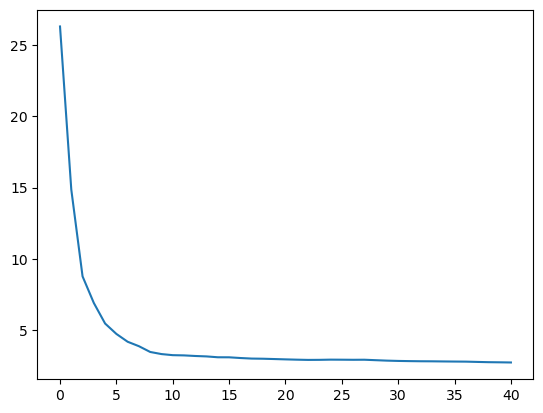

In [25]:
loss_pas = usm.plot_loss(X_test, Y_test, coeff_pas, inter_pas, is_print = True)

In [26]:
coeff_act, inter_act = usm.uncertain_sampling(X_train, Y_train, 
                           init = 'zero', 
                           query = 'active',
                           width = 1e0,
                           max_iter = 4e2, 
                           step_size = 2e-1, 
                           warm_start = 0,
                           sep_valid = True,
                           valid_ratio = 0.2,
                           update_freq = 1,
                           batch_size = 10,
                           method = 'linear_regression')

100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 2932.87it/s]


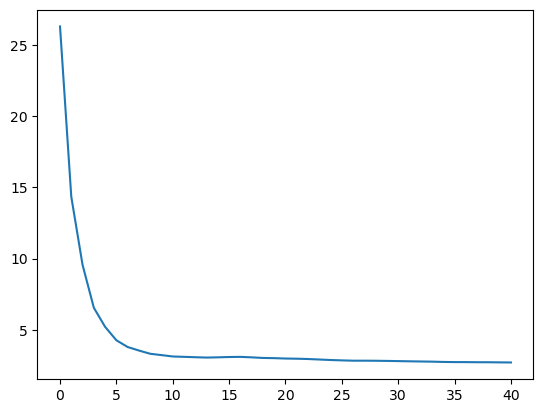

In [27]:
loss_act = usm.plot_loss(X_test, Y_test, coeff_act, inter_act, is_print = True)

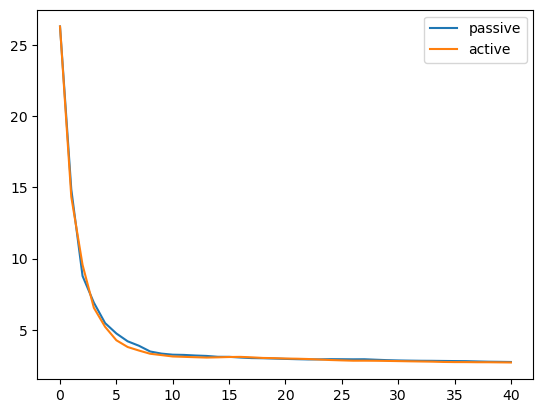

In [28]:
plt.plot(loss_pas, label = 'passive')
plt.plot(loss_act, label = 'active')
plt.legend()
plt.show()

In [49]:
poly_X_train = pairwise_kernels(X = X_train, metric='poly', degree = 3)
poly_X_test = pairwise_kernels(X = X_test, Y = X_train, metric='poly', degree = 3)

In [50]:
coeff_pas, inter_pas = usm.uncertain_sampling(poly_X_train, Y_train, 
                           init = 'zero', 
                           query = 'passive',
                           max_iter = 4e2, 
                           step_size = 2e-4, 
                           batch_size = 10,
                           method = 'linear_regression')

100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 10001.92it/s]


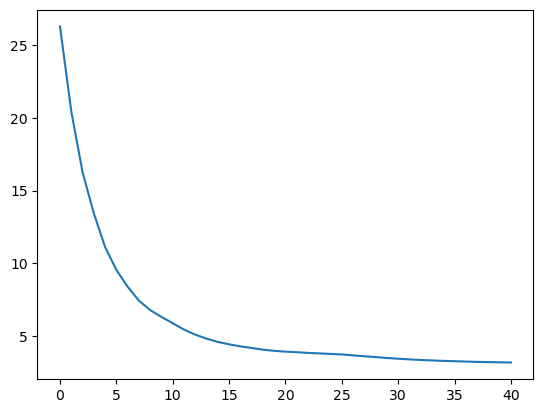

In [51]:
loss_pas = usm.plot_loss(poly_X_test, Y_test, coeff_pas, inter_pas, is_print = True)

In [52]:
coeff_act, inter_act = usm.uncertain_sampling(poly_X_train, Y_train, 
                           init = 'zero', 
                           query = 'active',
                           width = 1e0,
                           max_iter = 4e2, 
                           step_size = 2e-4, 
                           warm_start = 0,
                           sep_valid = True,
                           valid_ratio = 1.0,
                           update_freq = 1,
                           batch_size = 10,
                           method = 'linear_regression')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 70.29it/s]


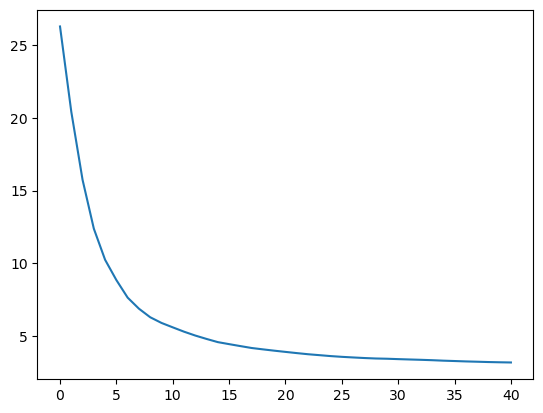

In [53]:
loss_act = usm.plot_loss(poly_X_test, Y_test, coeff_act, inter_act, is_print = True)

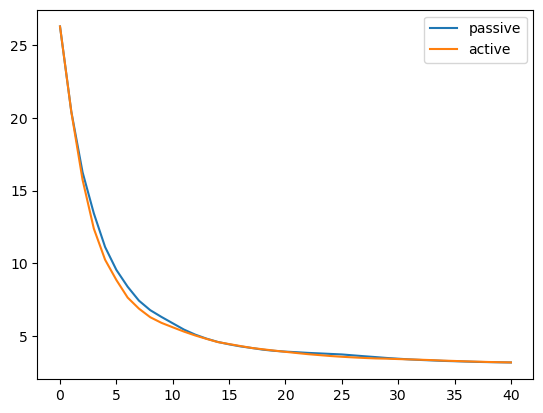

In [54]:
plt.plot(loss_pas, label = 'passive')
plt.plot(loss_act, label = 'active')
plt.legend()
plt.show()

In [55]:
rbf_X_train = pairwise_kernels(X = X_train, metric='rbf')
rbf_X_test = pairwise_kernels(X = X_test, Y = X_train, metric='rbf')

In [56]:
coeff_pas, inter_pas = usm.uncertain_sampling(rbf_X_train, Y_train, 
                           init = 'zero', 
                           query = 'passive',
                           max_iter = 4e2, 
                           step_size = 1e-3, 
                           batch_size = 10,
                           method = 'linear_regression')

100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 10019.24it/s]


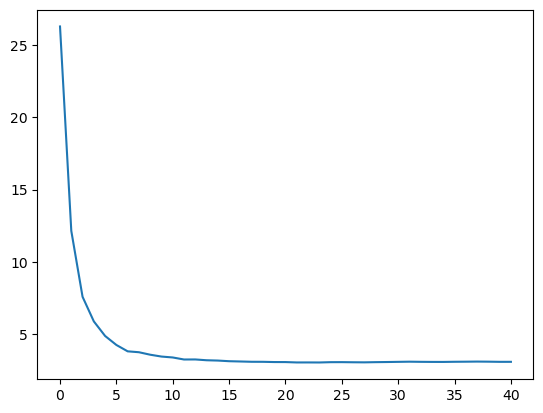

In [57]:
loss_pas = usm.plot_loss(rbf_X_test, Y_test, coeff_pas, inter_pas, is_print = True)

In [58]:
coeff_act, inter_act = usm.uncertain_sampling(rbf_X_train, Y_train, 
                           init = 'zero', 
                           query = 'active',
                           width = 1e0,
                           max_iter = 4e2, 
                           step_size = 1e-3, 
                           warm_start = 0,
                           sep_valid = True,
                           valid_ratio = 1.0,
                           update_freq = 1,
                           batch_size = 10,
                           method = 'linear_regression')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.07it/s]


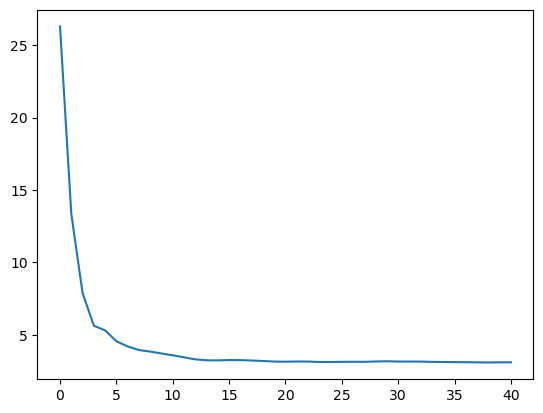

In [59]:
loss_act = usm.plot_loss(rbf_X_test, Y_test, coeff_act, inter_act, is_print = True)

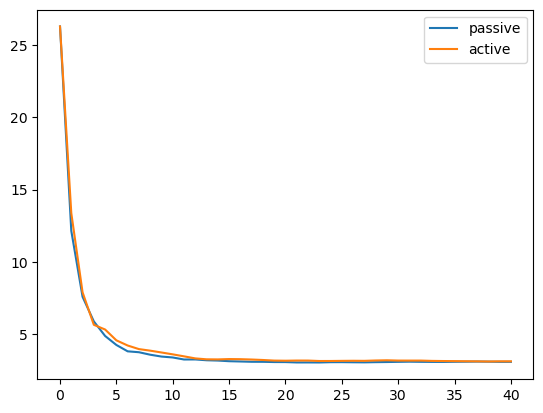

In [60]:
plt.plot(loss_pas, label = 'passive')
plt.plot(loss_act, label = 'active')
plt.legend()
plt.show()

In [67]:
trials = 30
steps = 200
batch_size = 2
is_first = True
for t in range(trials):
    print("************************\n trial", t + 1)
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, test_size=0.20)
    poly_X_train = pairwise_kernels(X = X_train, metric='poly')
    poly_X_test = pairwise_kernels(X = X_test, Y = X_train, metric='poly')
    init = np.random.normal(size = (poly_X_train.shape[1] + 1, 1), scale = 1e-2)
    coeff_pas, inter_pas = usm.uncertain_sampling(poly_X_train, Y_train,
                                              init_method = 'fixed',
                                              init = np.copy(init), 
                                              query = 'passive',
                                              max_iter = steps, 
                                              step_size = 2e-4, 
                                              batch_size = batch_size,
                                              method = 'linear_regression')
    coeff_act, inter_act = usm.uncertain_sampling(poly_X_train, Y_train,
                                              init_method = 'fixed',
                                              init = np.copy(init), 
                                              query = 'active',
                                              width = 1e0,
                                              max_iter = steps, 
                                              step_size = 2e-4, 
                                              warm_start = 0,
                                              sep_valid = True,
                                              valid_ratio = 0.5,
                                              update_freq = 1,
                                              batch_size = batch_size,
                                              method = 'linear_regression')
    if is_first:
        loss_pas = np.asarray(usm.plot_loss(poly_X_test, Y_test, coeff_pas, inter_pas)) / float(trials)
        loss_act = np.asarray(usm.plot_loss(poly_X_test, Y_test, coeff_act, inter_act)) / float(trials)
        is_first = False
    else:
        loss_pas += np.asarray(usm.plot_loss(poly_X_test, Y_test, coeff_pas, inter_pas)) / float(trials)
        loss_act += np.asarray(usm.plot_loss(poly_X_test, Y_test, coeff_act, inter_act)) / float(trials)

************************
 trial 1


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 355.14it/s]


************************
 trial 2


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.70it/s]


************************
 trial 3


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 317.23it/s]


************************
 trial 4


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.61it/s]


************************
 trial 5


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 363.31it/s]


************************
 trial 6


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 324.33it/s]


************************
 trial 7


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 347.34it/s]


************************
 trial 8


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 325.23it/s]


************************
 trial 9


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 350.74it/s]


************************
 trial 10


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 316.60it/s]


************************
 trial 11


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 285.85it/s]


************************
 trial 12


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 337.06it/s]


************************
 trial 13


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.65it/s]


************************
 trial 14


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 366.77it/s]


************************
 trial 15


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 350.65it/s]


************************
 trial 16


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 370.52it/s]


************************
 trial 17


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 296.46it/s]


************************
 trial 18


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 364.97it/s]


************************
 trial 19


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 367.72it/s]


************************
 trial 20


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.59it/s]


************************
 trial 21


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 351.54it/s]


************************
 trial 22


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 339.95it/s]


************************
 trial 23


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 346.21it/s]


************************
 trial 24


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 285.55it/s]


************************
 trial 25


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.83it/s]


************************
 trial 26


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.91it/s]


************************
 trial 27


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 363.63it/s]


************************
 trial 28


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 346.98it/s]


************************
 trial 29


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.73it/s]


************************
 trial 30


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.83it/s]


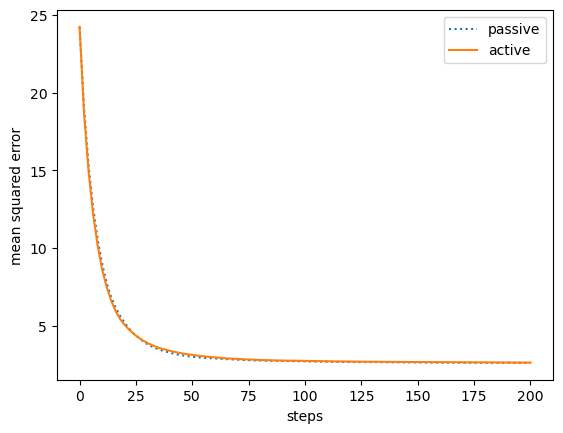

In [68]:
grid = np.arange(0, steps, batch_size)
grid = np.concatenate((grid, np.atleast_1d(steps)))
plt.plot(grid, loss_pas, label = 'passive', linestyle = 'dotted')
plt.plot(grid, loss_act, label = 'active', linestyle = 'solid')
plt.legend()
plt.xlabel('steps')
plt.ylabel('mean squared error')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


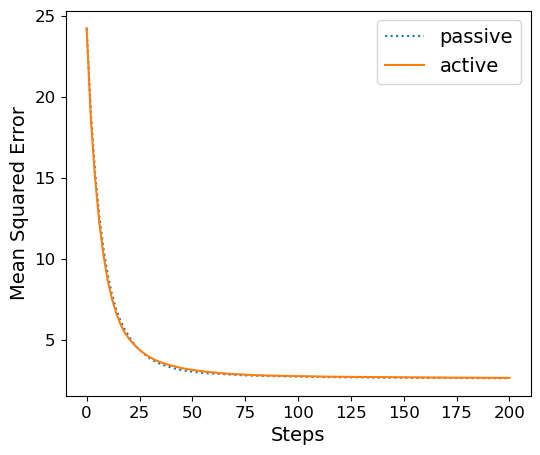

In [70]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

ax.plot(grid, loss_pas, label = 'passive', linestyle = 'dotted')
ax.plot(grid, loss_act, label = 'active', linestyle = 'solid')


ax.legend(fontsize=14)
ax.set_xlabel('Steps', fontsize=14)
ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.savefig("Exp2_qsar.jpg", bbox_inches='tight')
plt.savefig("Exp2_qsar.eps", bbox_inches='tight')
plt.show()